# Background noise

**Scott Prahl**

**Nov 2025**

In [1]:
%config InlineBackend.figure_format = 'retina'

import sys
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt

if sys.platform == "emscripten":
    import piplite

    await piplite.install("laserbeamsize")

import laserbeamsize as lbs

In [2]:
if sys.platform == "emscripten":
    repo = "images/"
else:
    repo = "https://github.com/scottprahl/laserbeamsize/raw/main/docs/images/"

## Why background is important

The `lbs.beam_size()` algorithm should work robustly for a variety of images.  However some images just have noise.  This tries to explain how the background may be managed.
 
Section 3.1 of ISO 11146-3 states

> Signals recorded as the measured power density distribution $E_\mathrm{meas}(x,y)$ can be divided into two parts: the “true” power density distribution $E(x,y)$ generated by the beam under test, and a possibly inhomogeneous background map $E_B(x,y)$ generated by other sources such as external or ambient radiation or by the sensor device itself (noise):

> $$
E_\mathrm{meas}(x,y) = E(x,y)+ E_B(x,y)
$$

> where the background signals can be further divided into a homogeneous part $E_\mathrm{B,offset}$ (baseline offset), an inhomogeneous part $E_\mathrm{B,inh(x,y)}$ (for example baseline tilt) and the high-frequency noise components $E_\mathrm{B,noise}(x,y)$.

> $$
E_B(x,y) = E_\mathrm{B,offset}(x,y) + E_\mathrm{B,inh}(x,y) + E_\mathrm{B,noise}(x,y)
$$

> NOTE: Usually, neither can the high-frequency noise components be corrected nor is it necessary to do so. Due to the integrations involved in calculating beam parameters the high-frequency noise components determine the intrinsic statistical errors and therefore affect only the reproducibility of the measurements, whereas the other background signals cause systematic errors.

The assumption in the description of high-frequency noise is that its contribution to, say, the horizontal center is negligible

$$
\int_{-\infty}^\infty \int_{-\infty}^\infty  x \cdot E_\mathrm{B,noise}(x,y)\,dxdy \,\ll\,
\int_{-\infty}^\infty \int_{-\infty}^\infty  x \cdot [E(x,y)-E_\mathrm{B,offset}(x,y)]\,dxdy
$$

and also for the diameter 

$$
\int_{-\infty}^\infty \int_{-\infty}^\infty  (x-x_c)^2 E_\mathrm{B,noise}(x,y)\,dxdy \,\ll\,
\int_{-\infty}^\infty \int_{-\infty}^\infty  (x-x_c)^2 [E(x,y)-E_\mathrm{B,offset}(x,y)]\,dxdy
$$

this places severe constraints on the statistics of the background noise terms.

Section 3.1 of ISO 11146-3 continues

> The background distribution can be characterized by its mean value $E_\mathrm{B,offset}$ and its standard deviation $E_{B, σ}$. If the variations of the background signal across the detector, which can be characterized by the differences of local mean values to the overall mean value, are smaller than the standard deviation $E_B,σ$ the detector background can be considered as homogeneous.

The assumption is that the statistics of homogeneous background noise are Poisson and the variance will be approximately equal to the mean value of the noise.  If a constant background offset is present as well, then the variance will be less than the mean.  This allows us to identify tilted backgrounds, for example.

> Before evaluating the beam parameters, background correction procedures have to be applied to prevent background signals in the wings of the distribution from dominating the integrals involved. In a first step a coarse correction has to be carried out by subtracting either a background map or an average background from the measured power density distribution. For detection systems having a constant background level across the full area of the sensor, average background level subtraction correction can be used. In all other cases the subtraction of the complete background map is necessary.

In the next section, the effect of failing to remove a constant background is discussed.  Later sections will describe how the background might be found and removed from an image.

> The subtraction of a background map or an average background determined from a background map may provide offset errors of less than 0.1 digits in most cases, but do not always result in a baseline offset of zero. Due to the statistical nature of the background noise (the baseline offset is defined as the average of all non-illuminated pixels), to fluctuations of ambient radiation sources, or to scattered light or other non-coherent light emissions caused by the laser (for example fluorescence and/or residual pump light), the baseline offset can only be determined exactly from the measured power density distribution. Even small baseline offsets can create large errors in the evaluation of parameters characterizing the measured power density distribution. Therefore, especially for small beams (beam widths of less than 0.25 times the detector dimensions), the additional procedures given in 3.4 have to be applied.

An offset error of 0.1 digits is extremely optimistic for systems that are not specifically designed to measure beam size -- quick experiments with some neutral density filters and a CCD camera come to mind.  

> As a result of a proper background subtraction there must exist negative noise values in the corrected power density distribution. These negative values have to be included in the further evaluation in order to allow compensation of positive noise amplitudes.

This is the part of the ISO standard that led to the version 2.0.0 rewrite.  Earlier versions of `laserbeamsize` managed background noise by subtracting the mean offset and then setting both positive and negative noise values (with a magnitude below a specified threshold) to zero.  

### The effect of constant background

As mentioned in the literature, image artifacts outside the beam can cause dramatic errors when the ISO 11146 algorithm is used.  Consider just finding the center in the horizontal direction.  We calculate the total power $P$ over the entire image of the beam

$$
P = \sum_{i=0}^{N-1} \sum_{j=0}^{M-1} E_{ij}
$$

and then locate the center of this beam with the following sum (that approximates the weighted integral)

$$
x_c \approx {1\over P} \sum_{i=0}^{N-1} \sum_{j=0}^{M-1} i \cdot E_{ij}
$$

Now if the image is zero outside the beam, the $E_{ij}=0$ for those pixels and these contribute *nothing* in either of the sums above.  

Now in the case of a beam image with constant *positive* background ($\varepsilon P_b$), 

$$
E_{ij}=E'_{ij} + \varepsilon P_b
$$ 

The calculation of $x_c$ becomes
$$
x_c \approx \frac{1}{P'} \sum_{i=0}^{N-1} \sum_{j=0}^{M-1} i E'_{ij} +  \frac{\varepsilon N(N-1)M P_b}{2P'} \approx
\frac{1}{P'} \sum_{i=0}^{N-1} \sum_{j=0}^{M-1} i E'_{ij} + \varepsilon\frac{N^2M}{2} \frac{P_b}{P'}
$$

Because the last term is always positive, the predicted center of the beam will 

* always be displaced to the right!
* have a greater error for greater image sizes
* be very sensitive to extra horizonal width

So, extra *background* across the image is problematic for locating the beam center.  Ideally, background image noise would be subtracted away and the non-beam pixels would all be zero.



### What is the background?

It is absolutely essential to remove the background.   There are a bunch of ways that the background might be determined.

1. Capture a background image with no beam (i.e., a dark image) and subtract that from images with the beam.  

2. Estimate the background using the pixel values in the corners of the image.

3. Use the corner estimate to tag all pixels in the image as illuminated or not.  Estimate the background using the un-illuminated pixels.

4. Some other elaborate statistical method

## Inhomogeneous background

### Using a dark image to correct background

Best practice, of course, is to gather more data.  Specifically, capture an image with the beam off and then one with the beam on.
Subtract the two.  `lbs.subtract_background_image(beam_image, dark_image)` makes this simple and avoids the wrap-around problem when subtracting uint8 or uint16 array (by converting to signed ints before subtraction)

The implicit assumption is that the background conditions for beam off and beam on are equivalent.  For a variety of reasons, this can be problematic.

In any case, this step is should be done before calling `beam_size()` because it will remove inhomogeneous background.

### Tilted background (i.e., background slopes across the image)

If, for some reason, there is non-uniform background light on the image sensor, then things are bad.  However, you might be able recover *something* by using the `subtract_tilted_background()` function.  The example illustrated below is sub-optimal because the image is saturated in the center.  

The function fits a plane to all the points around the perimeter of the image, given by this mask:

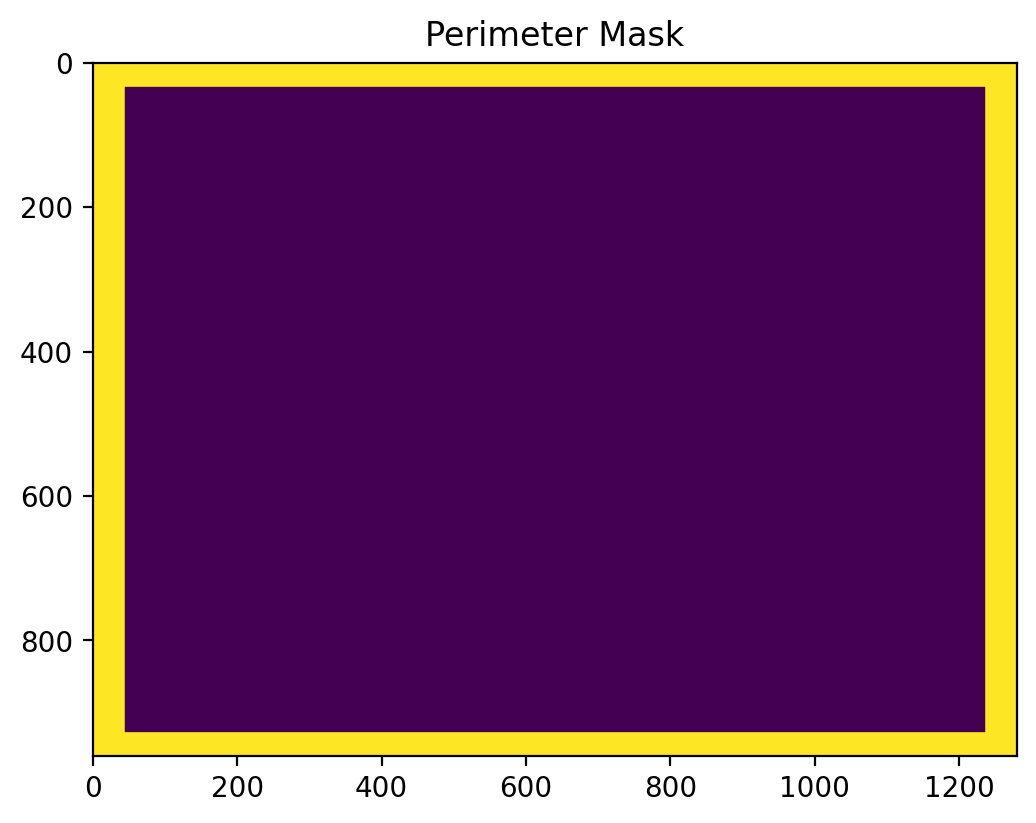

In [3]:
# read the original image file with tilted background
tilted = iio.imread(repo + "FBWR_151.pgm")
mask = lbs.perimeter_mask(tilted)
plt.imshow(mask)
plt.title("Perimeter Mask")
plt.show()

Then, it will subtract this plane from the image to remove the tilt.

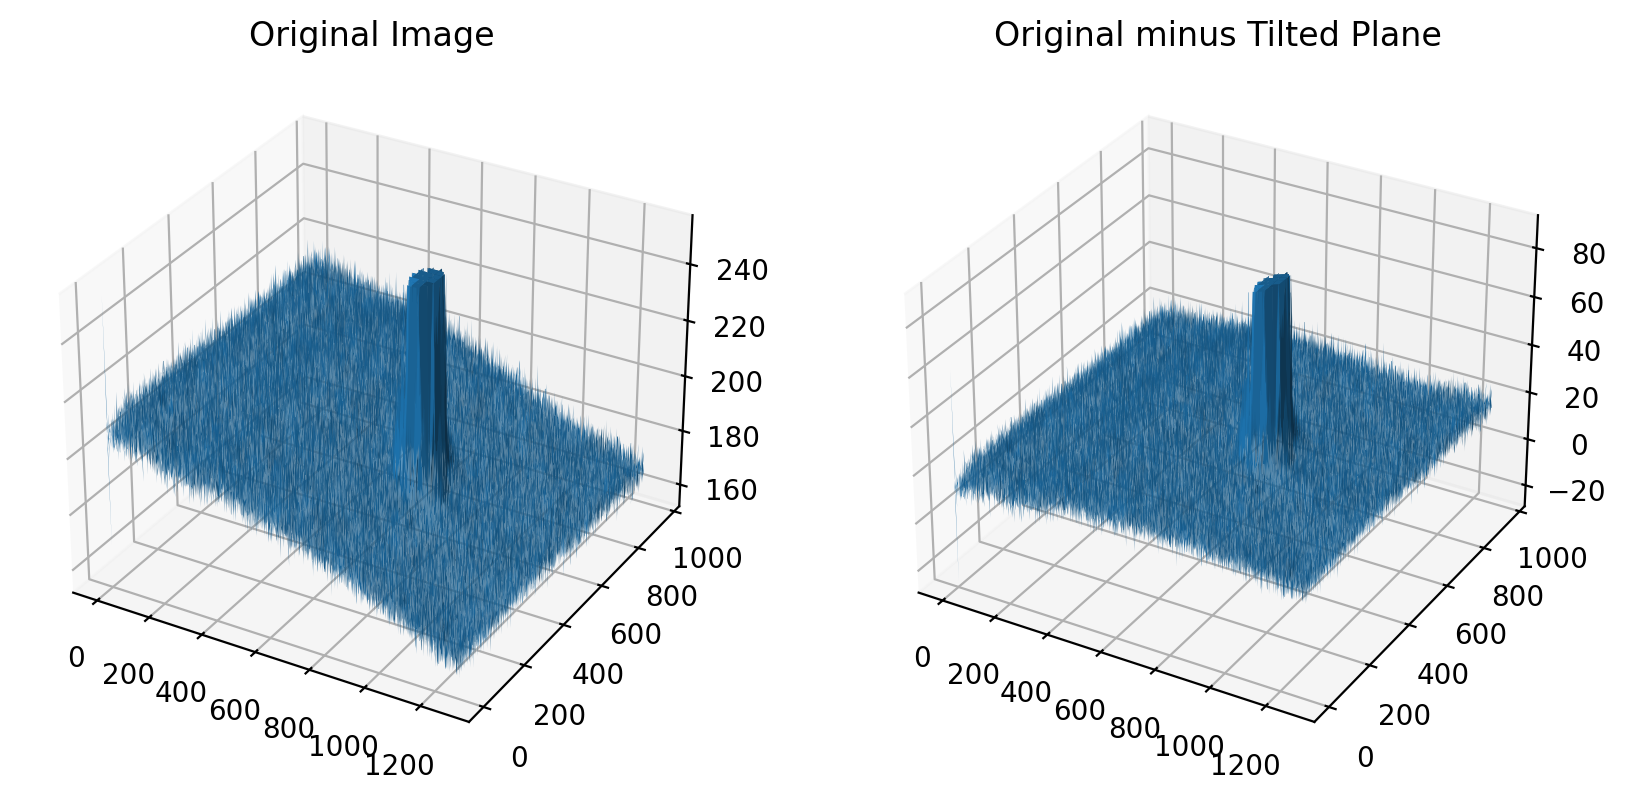

In [4]:
# create an image with the background removed
untilted = lbs.subtract_tilted_background(tilted)

v, h = untilted.shape
X, Y = np.meshgrid(range(h), range(v))

fig = plt.figure(figsize=(10, 5))

# show the 3D rotated projection
ax = fig.add_subplot(121, projection="3d")
ax.plot_surface(X, Y, tilted)
ax.set_title("Original Image")

ax = fig.add_subplot(122, projection="3d")
ax.plot_surface(X, Y, untilted)
ax.set_title("Original minus Tilted Plane")

plt.show()

If we ignore the tilt, then the default analysis finds the center, but cuts off the edges of the beam as well.  The result is that the analysis returns diameters that are smaller than they should be.

> As can be seen below, this is a terrible image of a beam.  The background is uneven, the center of the beam saturates the detector at 255, and background offset on edge is more than 200 counts!

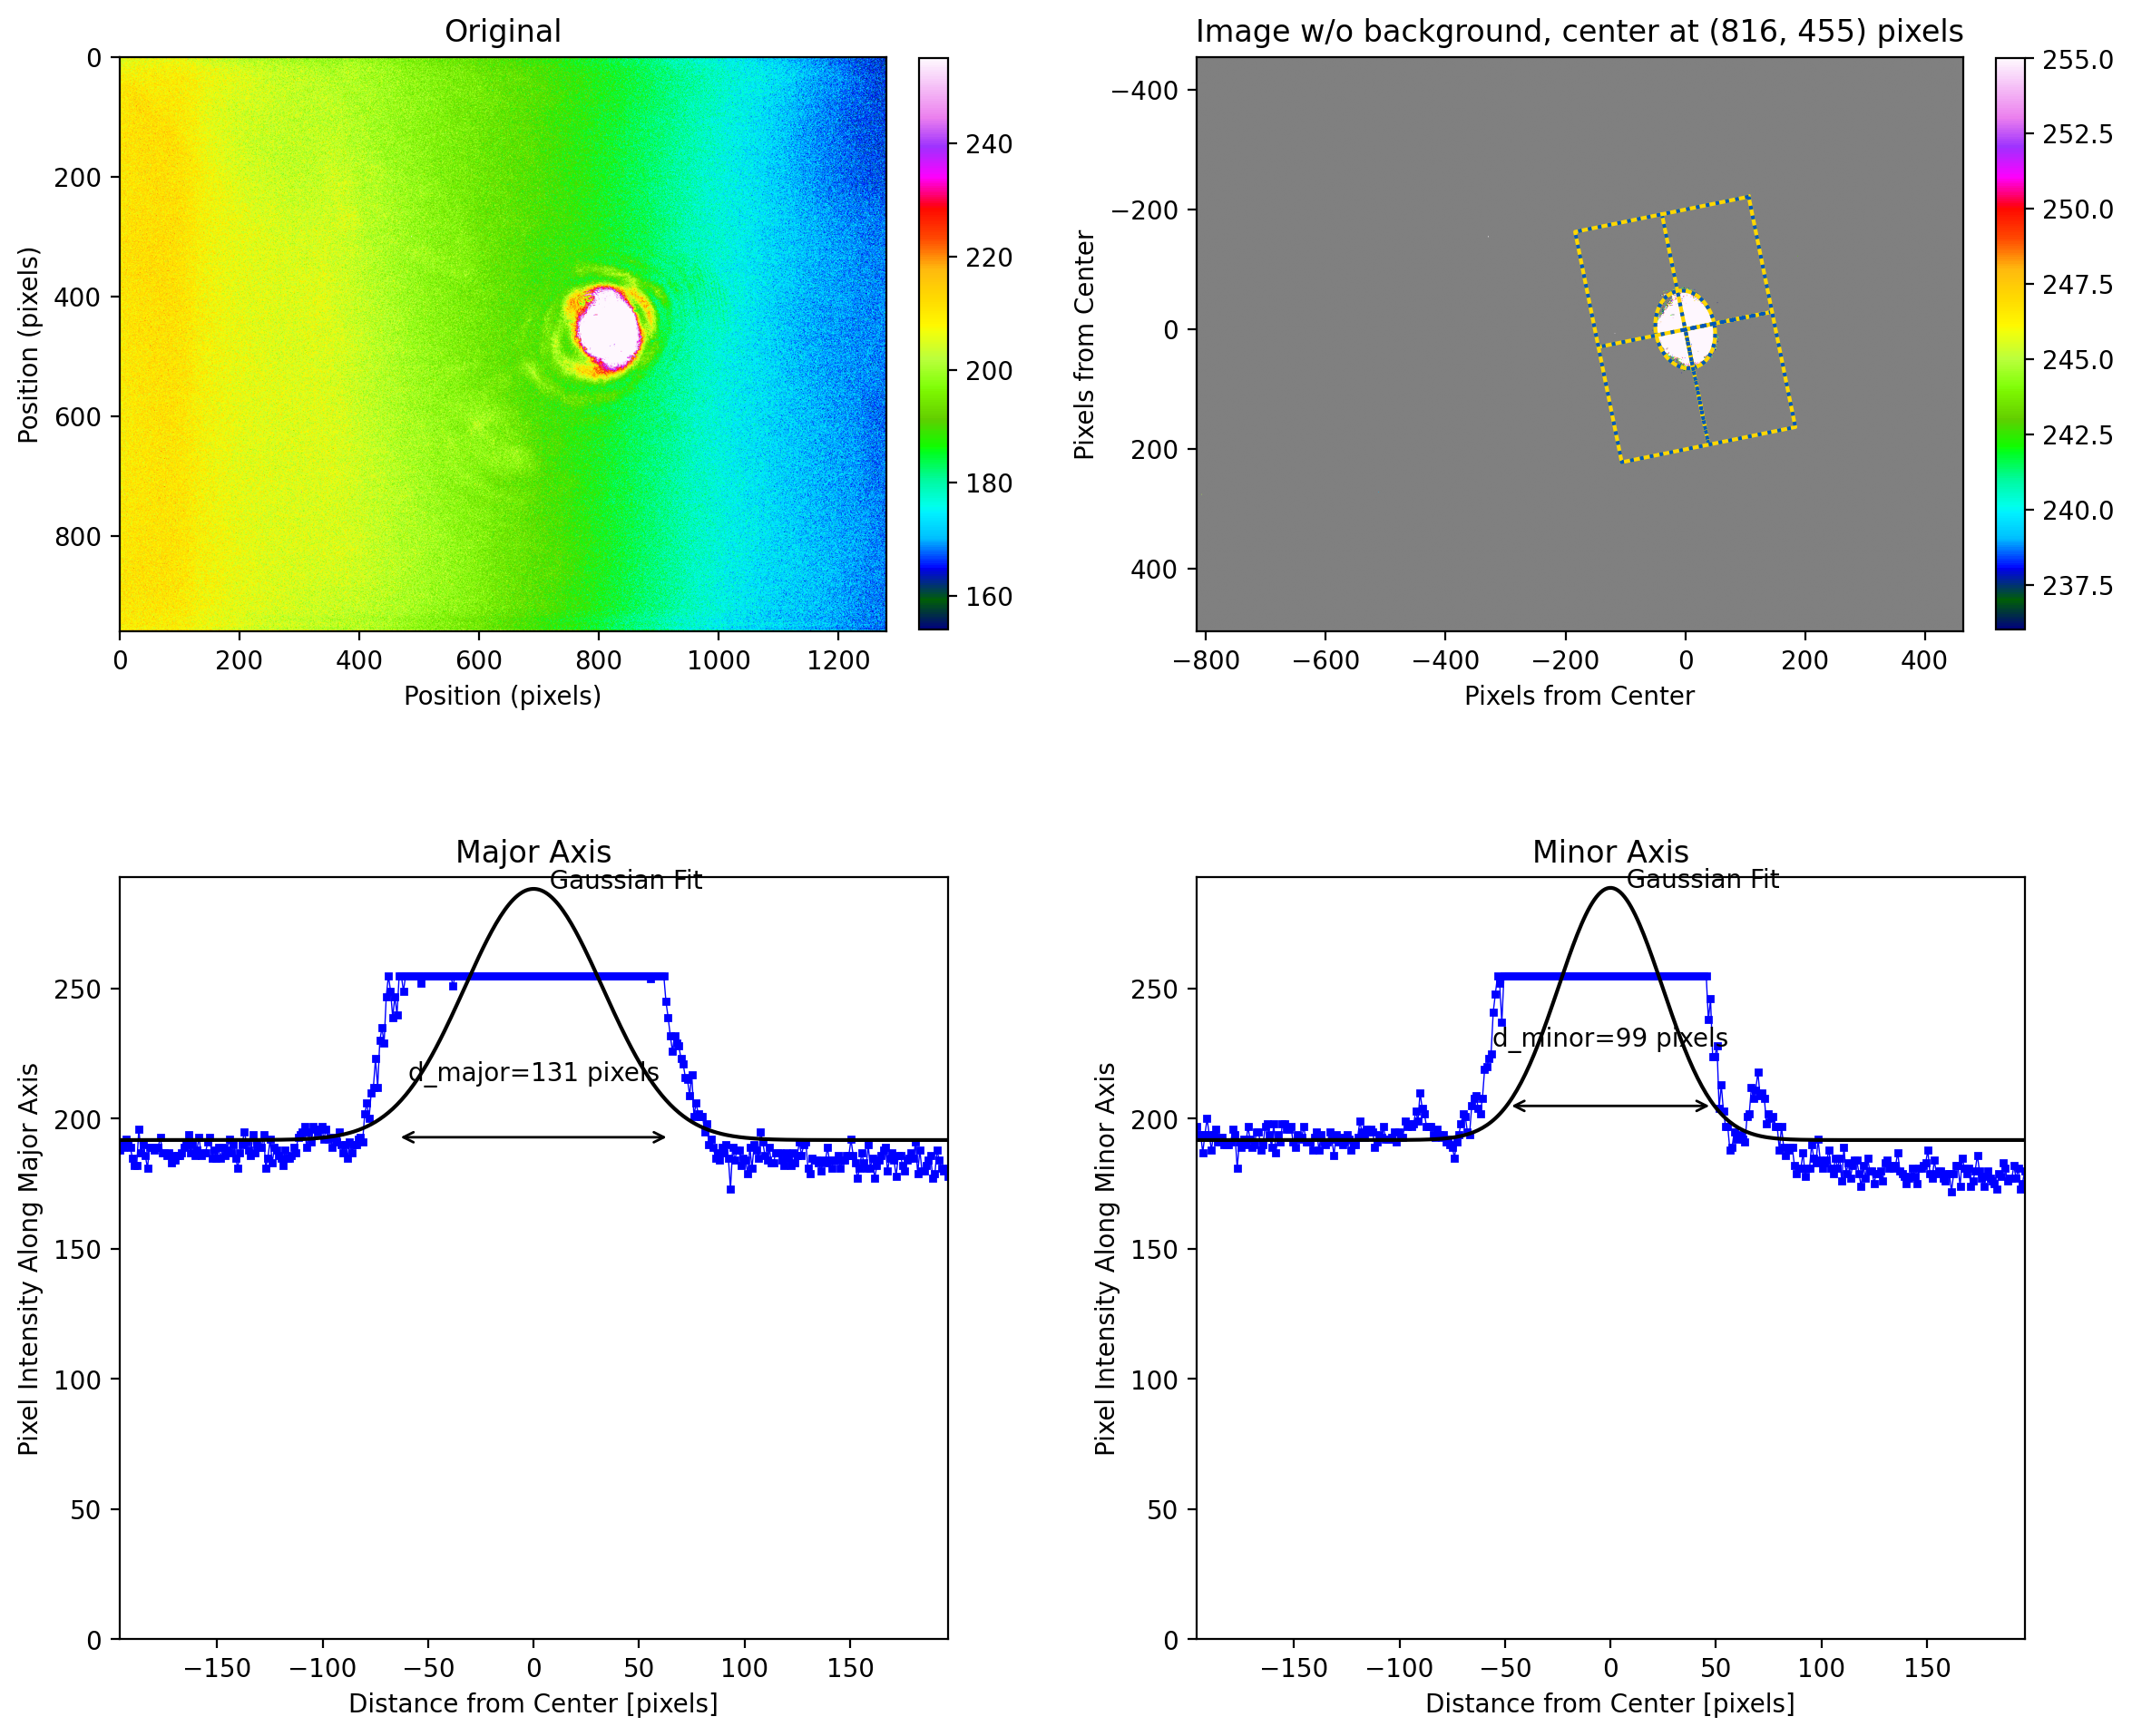

In [5]:
lbs.plot_image_analysis(tilted, iso_noise=False)

If we analyze the untilted image, then we get a beam size that is nearly 4X as large as the result from the tilted image.

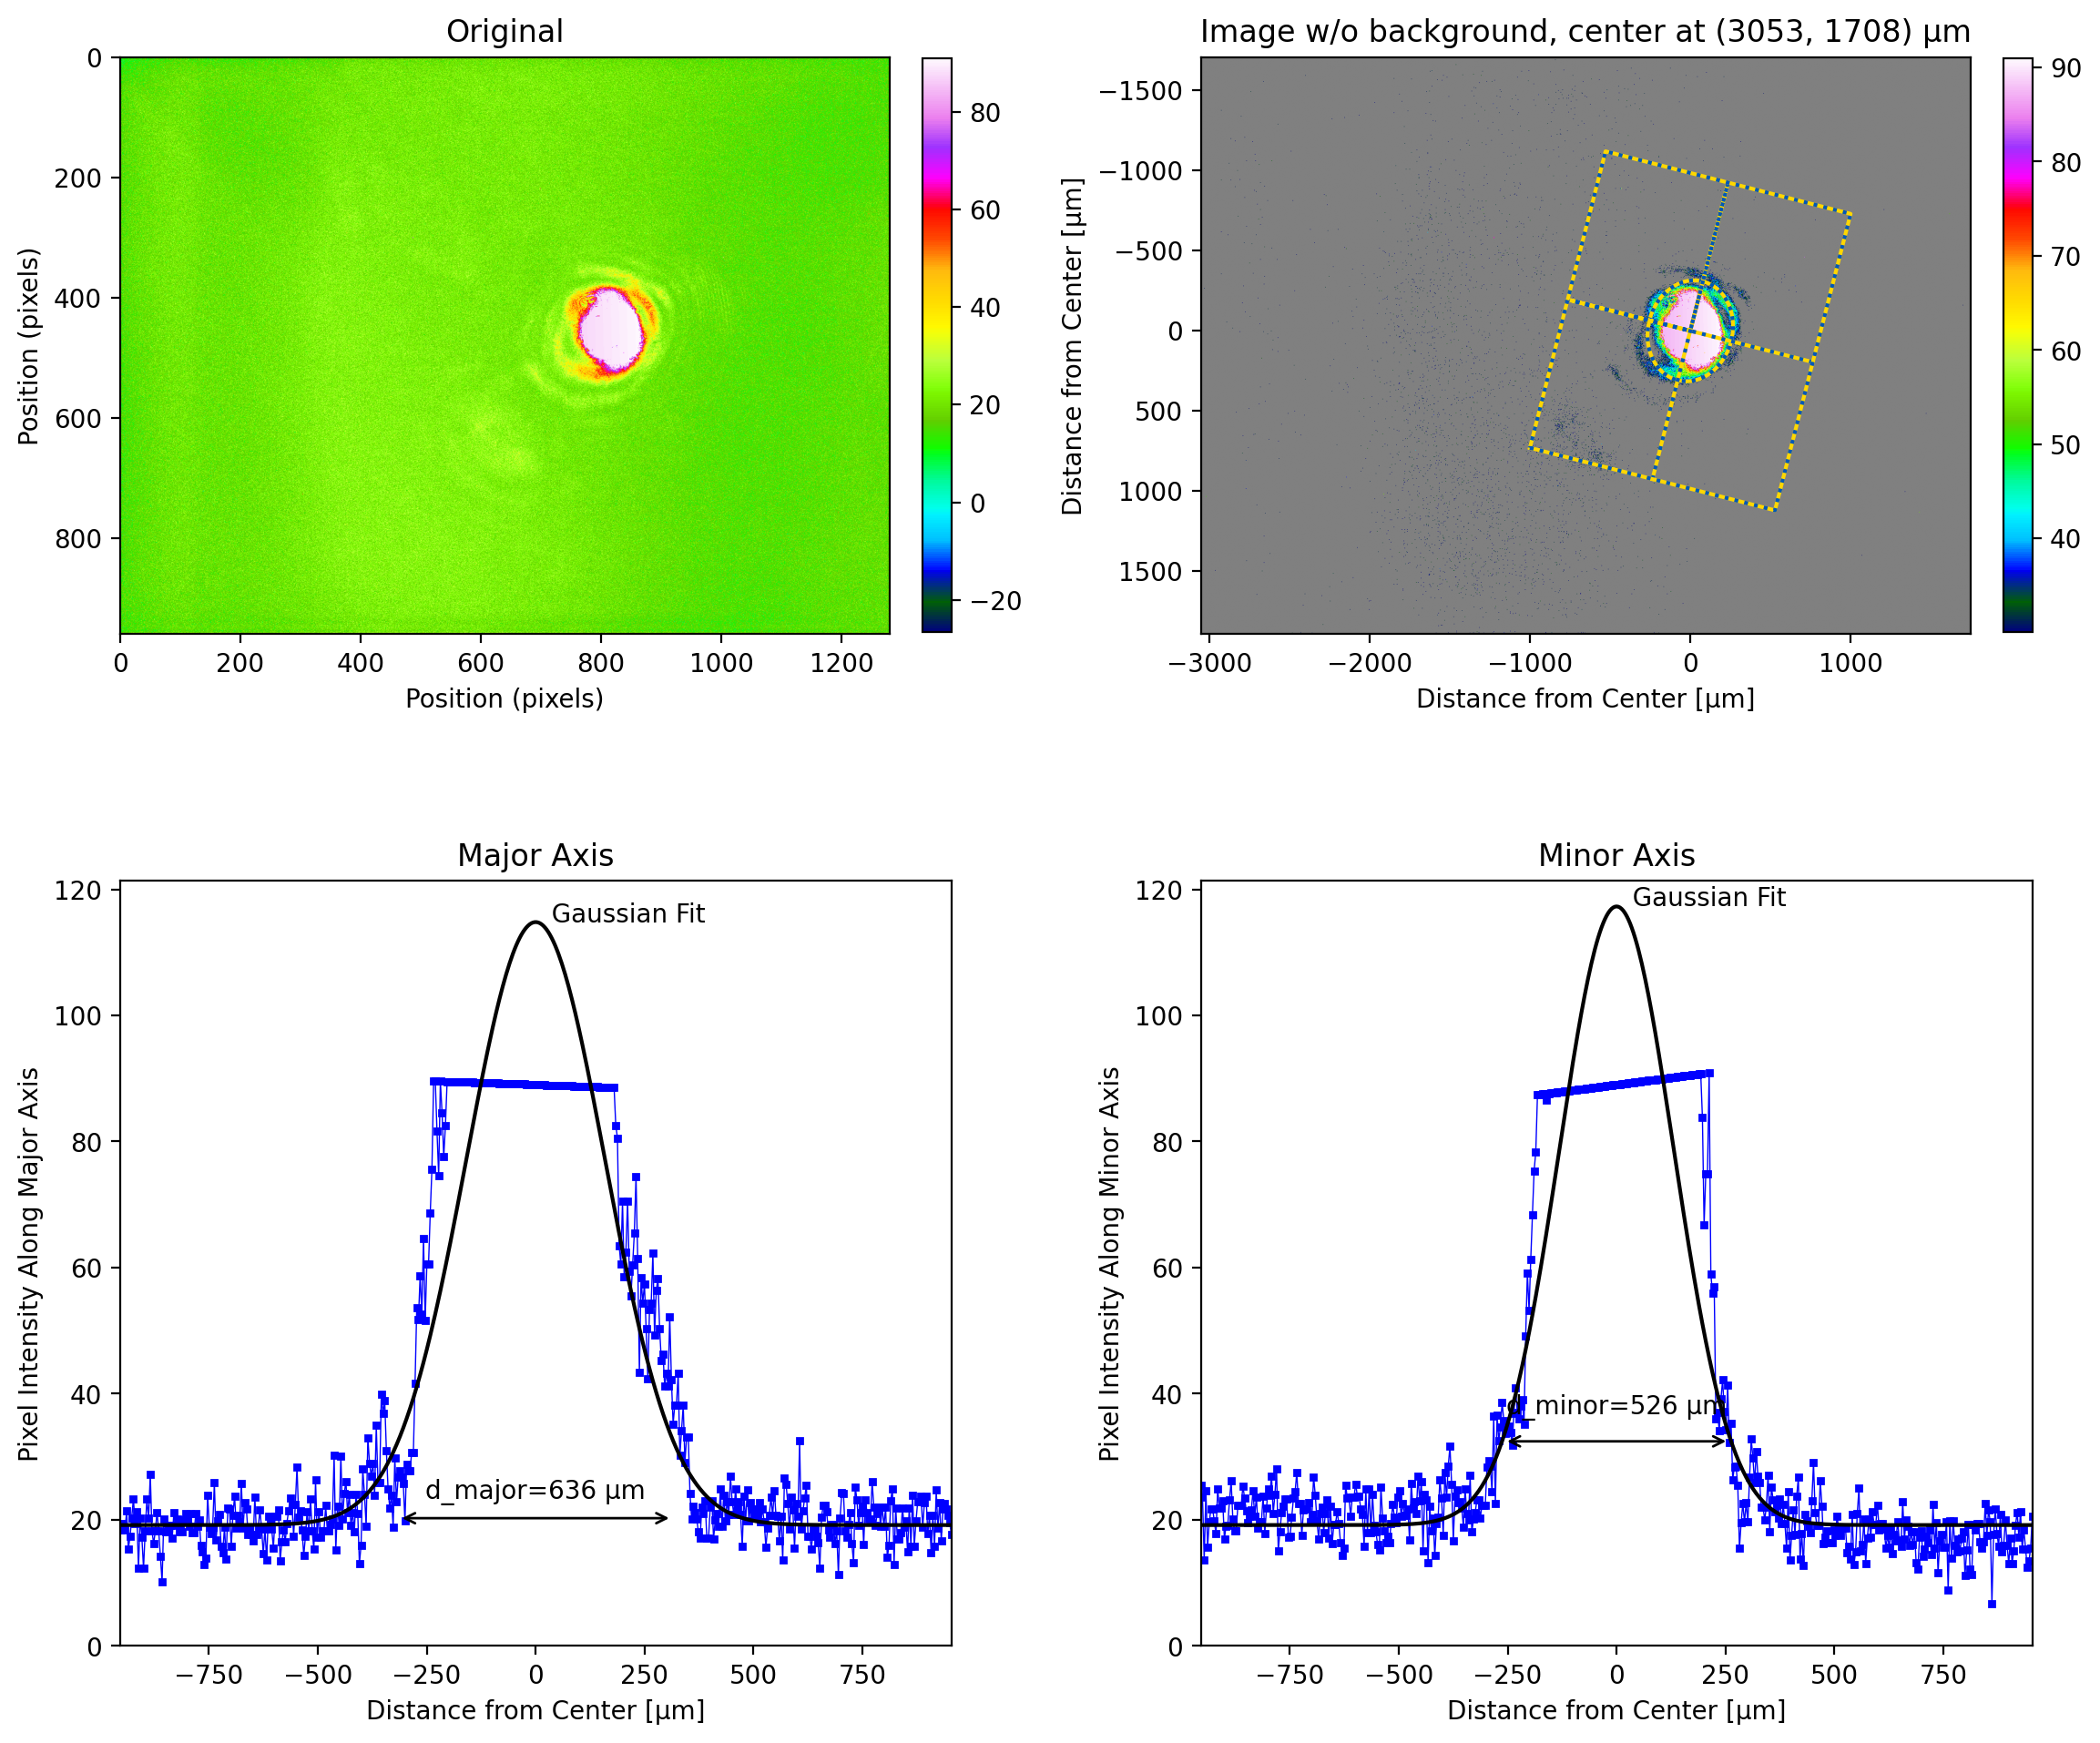

In [6]:
lbs.plot_image_analysis(untilted, pixel_size=3.75, iso_noise=False)

## Estimating a constant background using two different techniques

One easy way to get the background value is to sample the pixels in the corners of the image and use those statistics.

A second way is to do the above and then threshold the image so all values less than the mean + nT * stdev are labelled as unilluminated.  The statistics of the unilluminated pixels are then obtained.

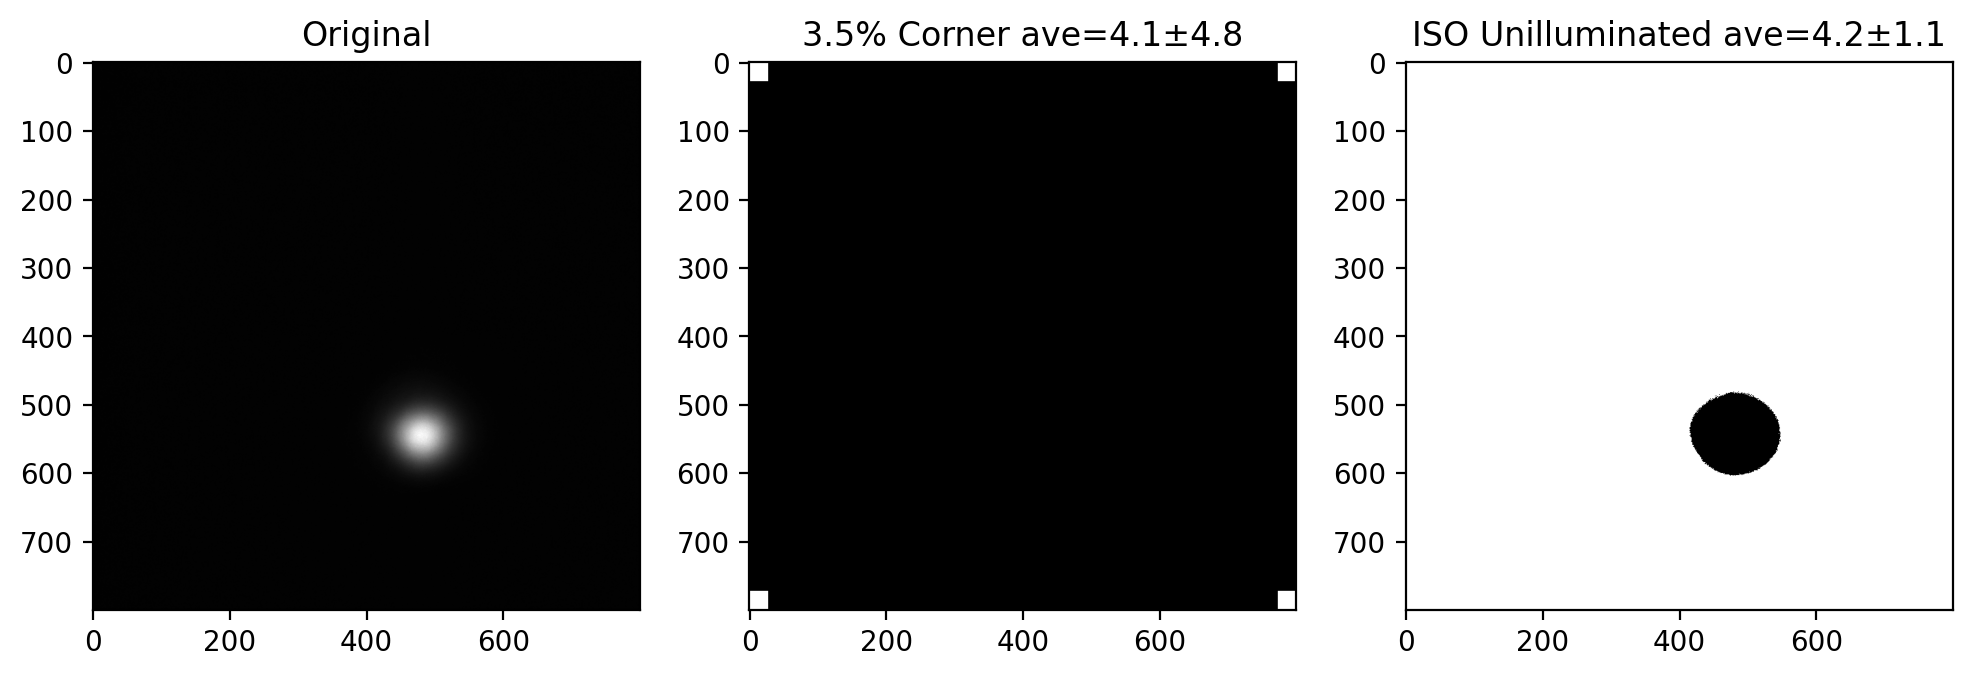

In [7]:
image1 = iio.imread(repo + "t-666mm.pgm")

plt.subplots(1, 3, figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.imshow(image1, cmap="gray")
plt.title("Original")
plt.subplot(1, 3, 2)
plt.imshow(lbs.corner_mask(image1), cmap="gray")
plt.title("3.5%% Corner ave=%.1f±%.1f" % lbs.corner_background(image1))
plt.subplot(1, 3, 3)
plt.imshow(lbs.iso_background_mask(image1), cmap="gray")
plt.title("ISO Unilluminated ave=%.1f±%.1f" % lbs.iso_background(image1))
plt.show()

The standard deviation of the ISO method is significantly smaller than when just the corners are used.  The graph below shows how larger corners eventually leads to the same standard deviation as the ISO method.

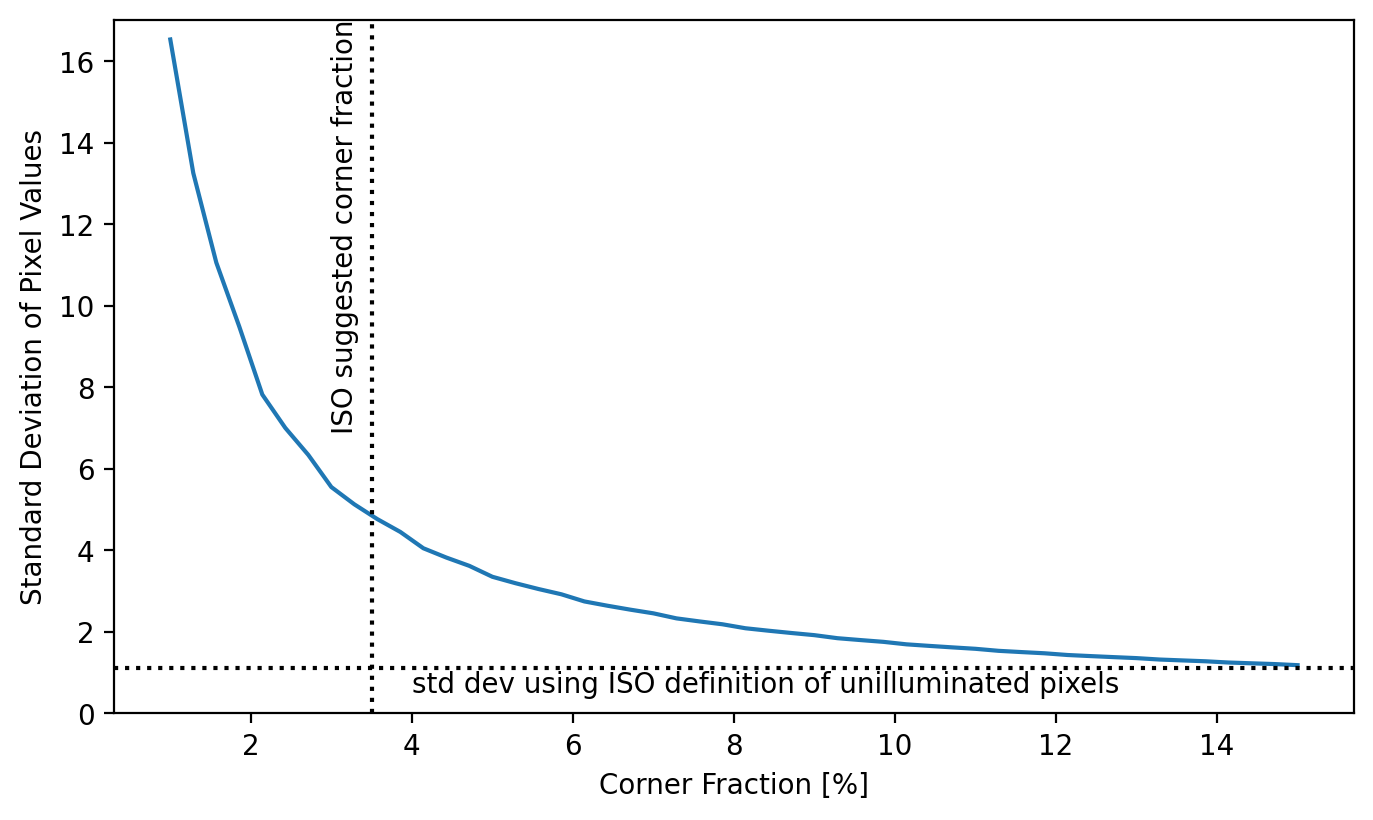

In [8]:
cf = np.linspace(0.01, 0.15)
ave = np.zeros_like(cf)
std = np.zeros_like(cf)
for i in range(len(cf)):
    ave[i], std[i] = lbs.corner_background(image1, corner_fraction=cf[i])

iso_ave, iso_std = lbs.iso_background(image1)
plt.plot(cf * 100, std)
plt.axhline(iso_std, ls=":", color="black")
plt.axvline(3.5, ls=":", color="black")
plt.xlabel("Corner Fraction [%]")
plt.ylabel("Standard Deviation of Pixel Values")
plt.text(3, 7, "ISO suggested corner fraction", rotation=90)
plt.text(4, 0.5, "std dev using ISO definition of unilluminated pixels")
plt.ylim(0, 17)
plt.show()

## Subtracting background

As ISO 11146-3 was quoted above
    
> As a result of a proper background subtraction there must exist negative noise values in the corrected power density distribution. These negative values have to be included in the further evaluation in order to allow compensation of positive noise amplitudes.

This makes sense, but it turns out that it does not always work.

The default `beam_size()` method subtracts the average `iso_background()` value from the entire image.  It then sets all pixels with values less than `nT*stdev` to zero.  This ensures that nearly all the background pixels are identically zero and therefore do not play a role when determining the center of the beam or its diameter.

The other method is obtained by passing `iso_noise=True`.  This returns an image with that has positive and negative noise pixels.  The result of both of these is shown below.

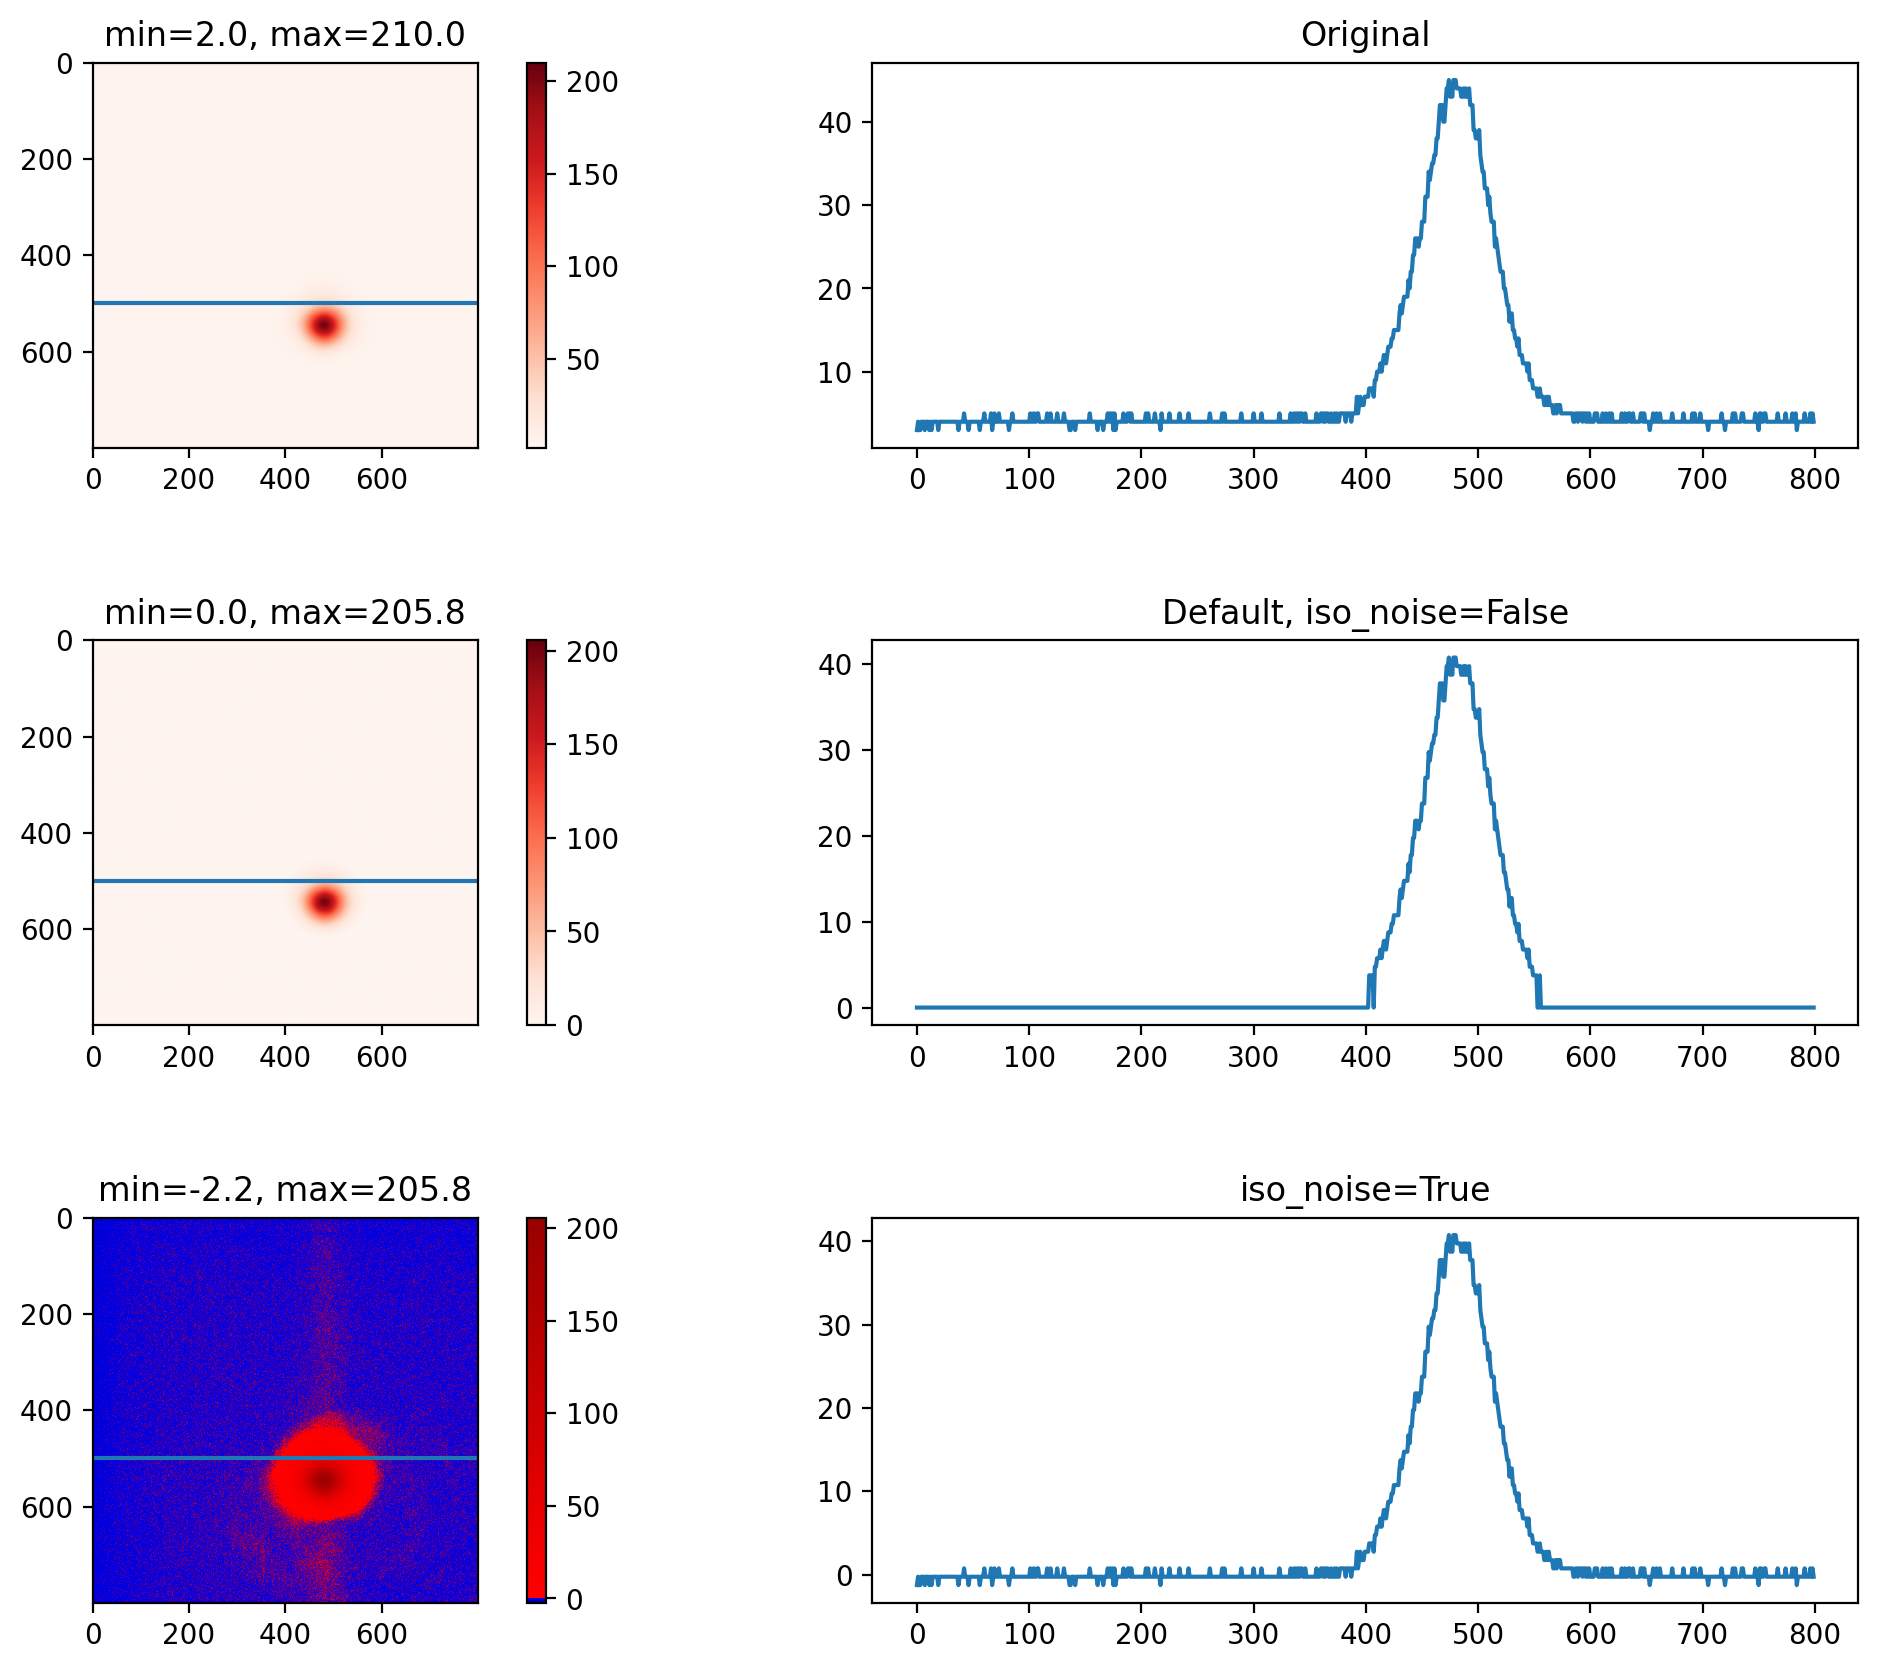

In [9]:
test = iio.imread(repo + "t-666mm.pgm")
row = 500

fig = plt.figure(figsize=(14, 10))

plt.subplot(3, 2, 1)
cm = lbs.create_plus_minus_cmap(test)
title = "min=%.1f, max=%.1f" % (np.min(test), np.max(test))
plt.imshow(test, cmap=cm)
plt.axhline(row)
plt.title(title)
plt.colorbar()

plt.subplot(3, 2, 2)
plt.plot(test[row, :])
plt.title("Original")

plt.subplot(3, 2, 3)
zero_noise_image = lbs.subtract_iso_background(test, iso_noise=False)
cm = lbs.create_plus_minus_cmap(zero_noise_image)
plt.imshow(zero_noise_image, cmap=cm)
plt.axhline(row)
plt.title("min=%.1f, max=%.1f" % (np.min(zero_noise_image), np.max(zero_noise_image)))
plt.colorbar()

plt.subplot(3, 2, 4)
plt.plot(zero_noise_image[row, :])
plt.title("Default, iso_noise=False")

plt.subplot(3, 2, 5)
negative_noise_image = lbs.subtract_iso_background(test, iso_noise=True)
cm = lbs.create_plus_minus_cmap(negative_noise_image)
plt.imshow(negative_noise_image, cmap=cm)
plt.axhline(row)

plt.title("min=%.1f, max=%.1f" % (np.min(negative_noise_image), np.max(negative_noise_image)))
plt.colorbar()

plt.subplot(3, 2, 6)
plt.plot(negative_noise_image[row, :])
plt.title("iso_noise=True")

plt.subplots_adjust(hspace=0.5, wspace=0.2)
plt.show()

The image can be analyzed using either method because it is nice and clean.

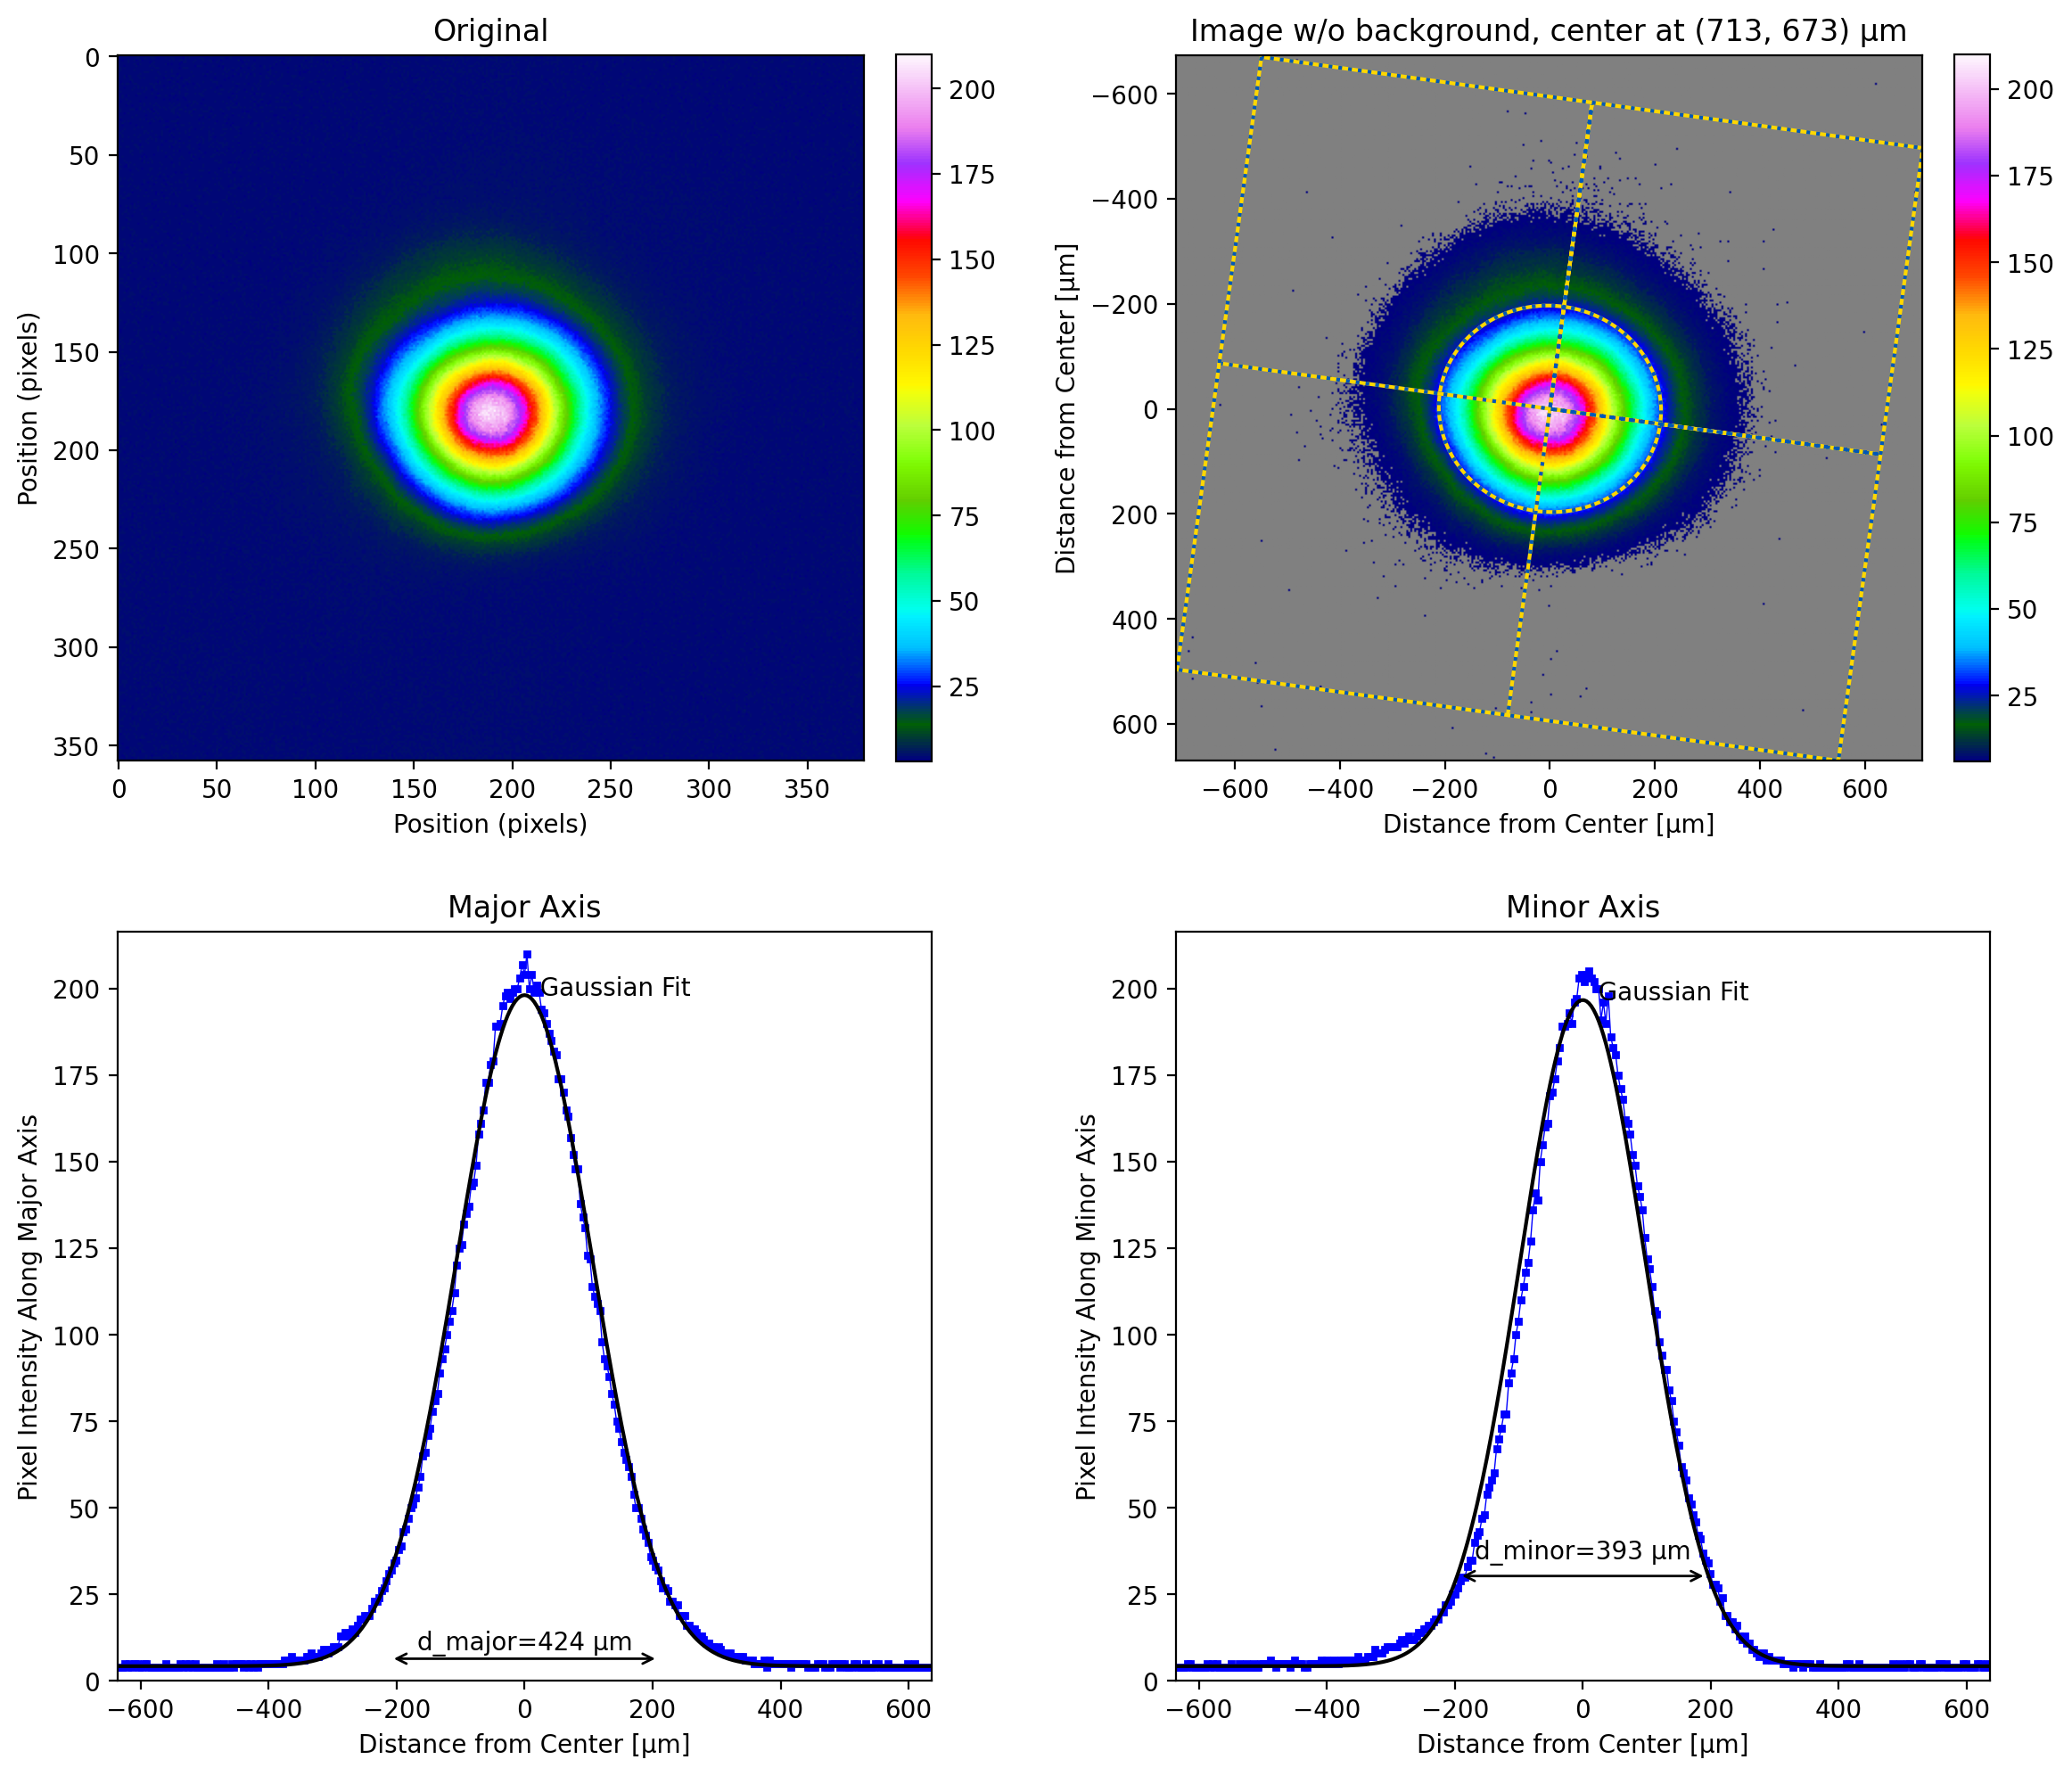

In [10]:
lbs.plot_image_analysis(test, crop=True, pixel_size=3.75, iso_noise=False)

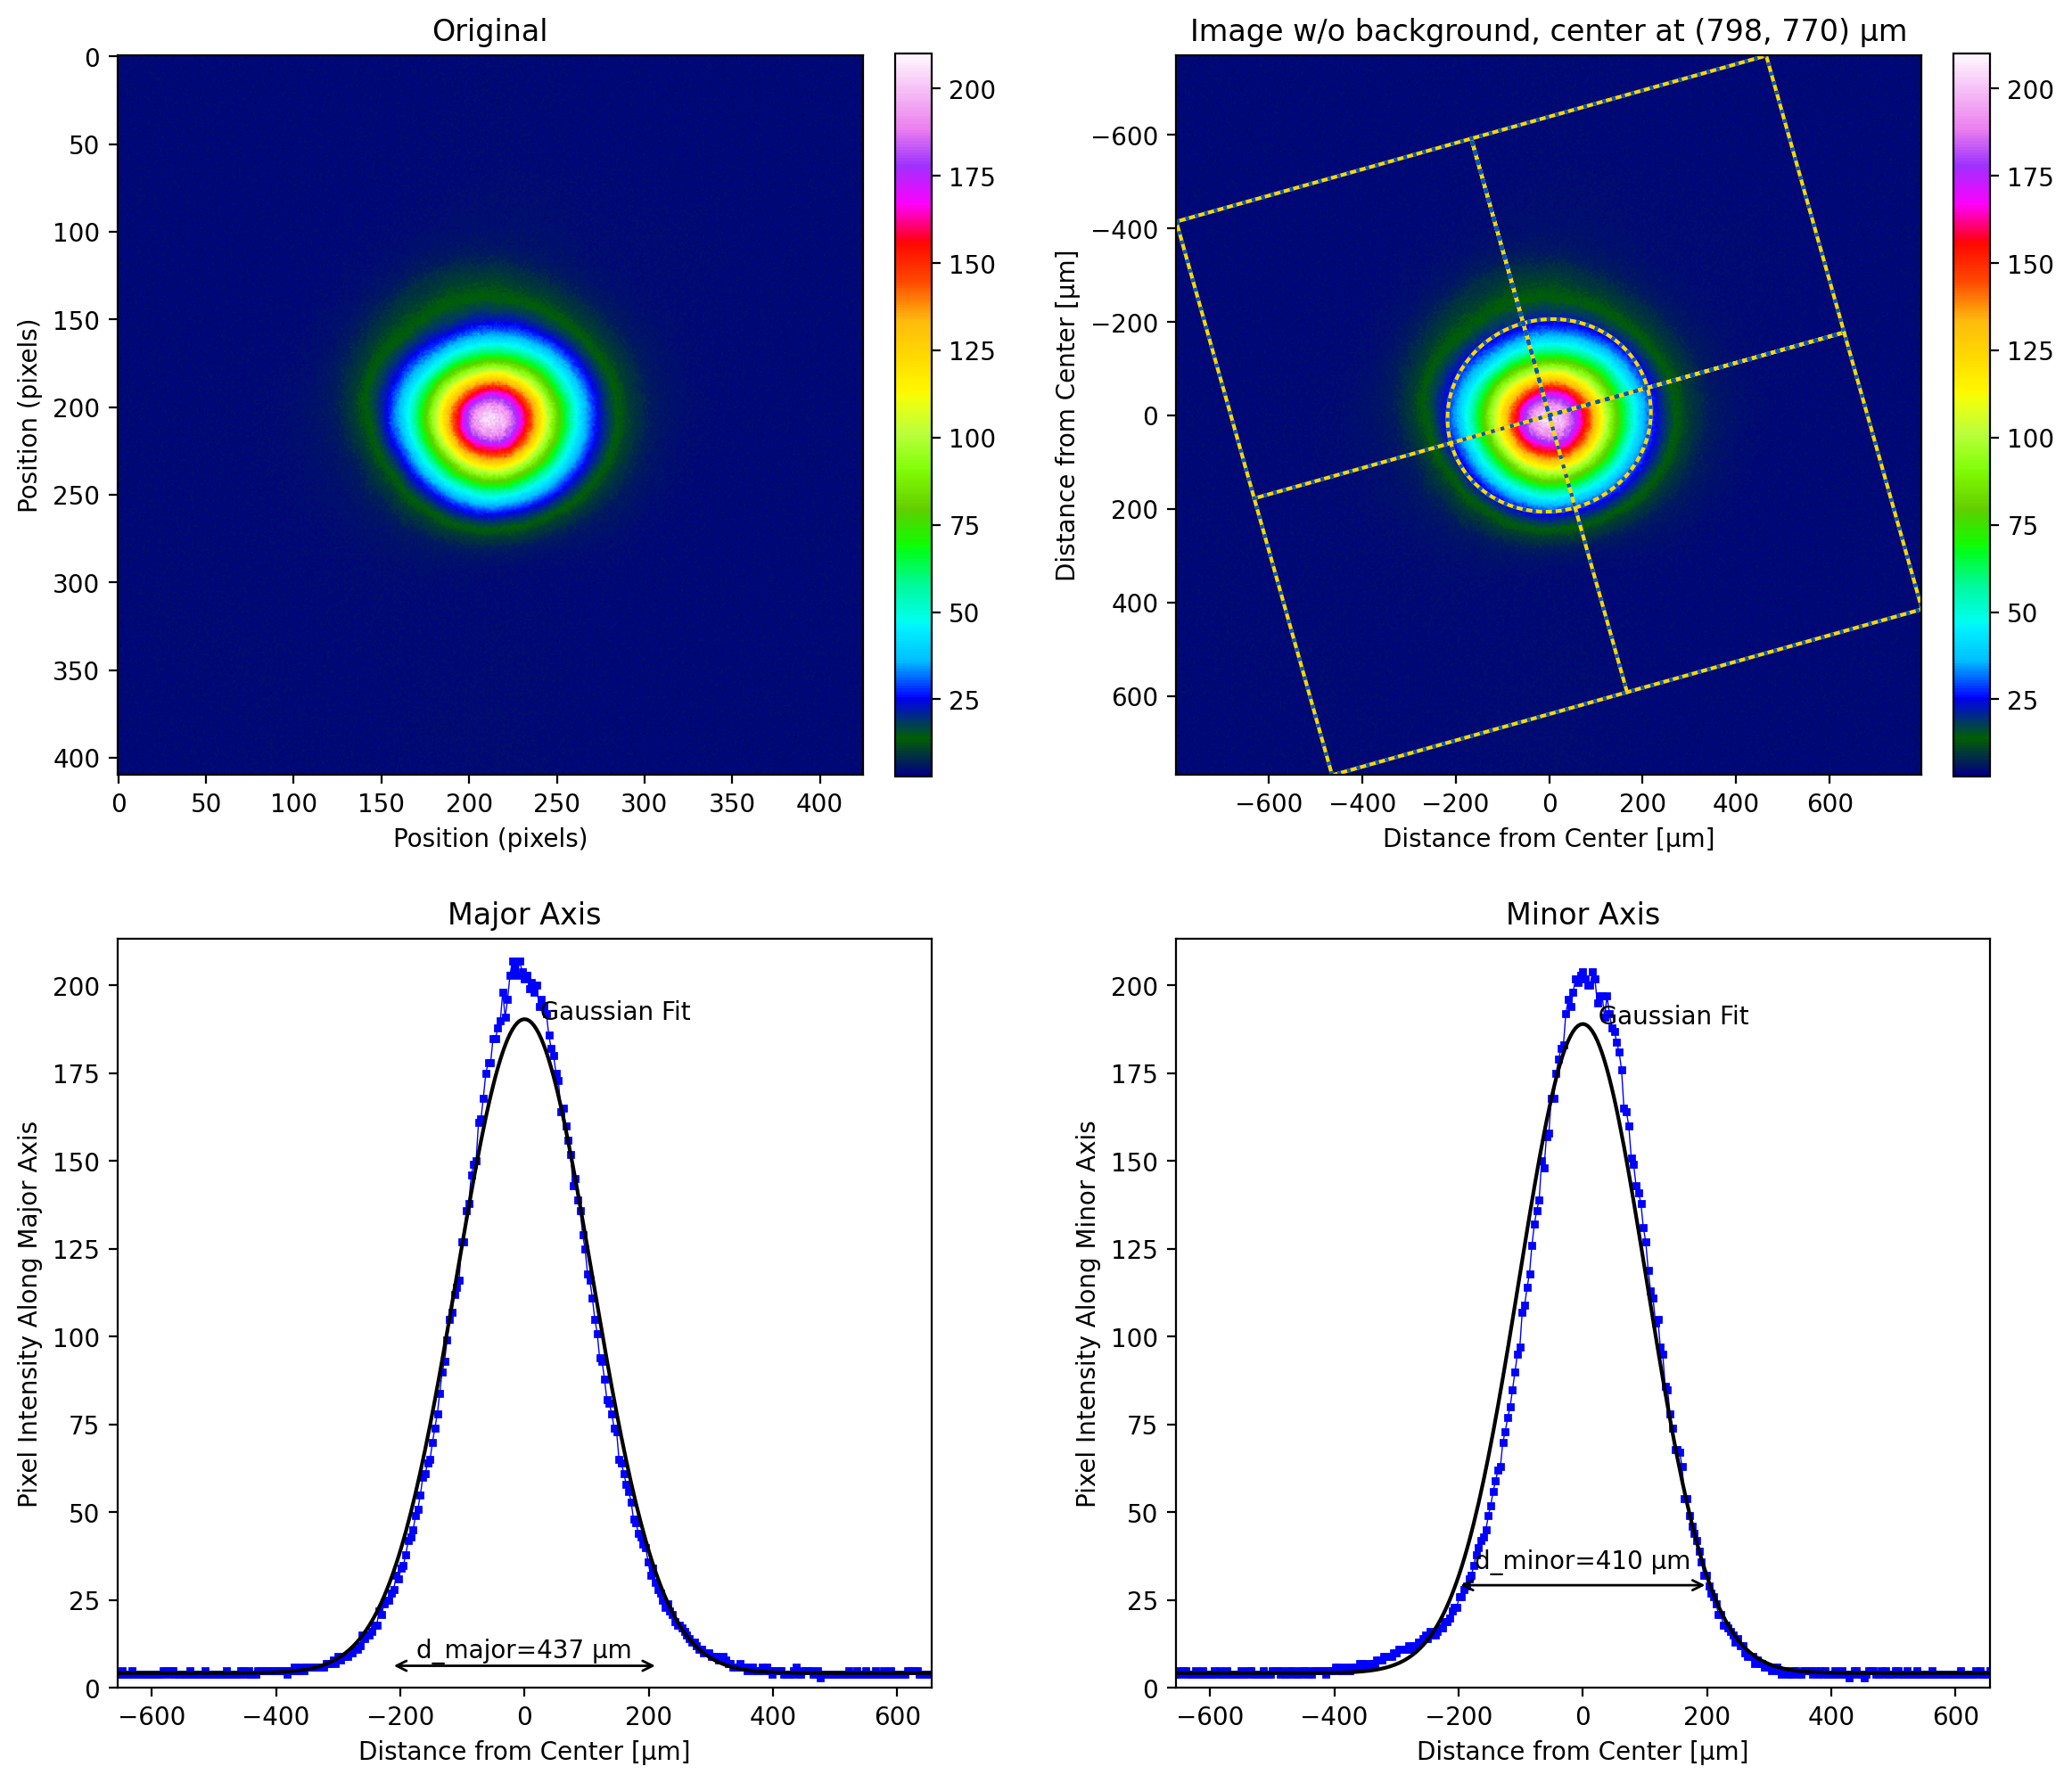

In [11]:
lbs.plot_image_analysis(test, crop=True, pixel_size=3.75, iso_noise=True)